In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from time import perf_counter
import seaborn as sns

def printmd(string):   
    display(Markdown(string))

In [3]:
tb_path = '/kaggle/input/gan-data/tbgenerated (2)/tb+generated/'
tb_path_list = os.listdir(tb_path)
tb_path_list = [tb_path + f for f in tb_path_list]

normal_path = '/kaggle/input/gan-data/normal_gamma_adjusted/normal_gamma_adjusted/'
normal_path_list = os.listdir(normal_path)
normal_path_list = [normal_path + f for f in normal_path_list]

In [4]:
df = pd.DataFrame({'Path': tb_path_list + normal_path_list})
df['Label'] = df['Path'].apply(lambda x: 0 if 'normal' in x else 1)
df['Label_String'] = df['Label'].apply(lambda x: 'normal' if x == 0 else 'Tuberculosis')

# Shuffle
df = df.sample(frac = 1.0).reset_index(drop = True)

# Display the first lines
pd.options.display.max_colwidth = 200
df.head()

,Path,Label,Label_String
0,/kaggle/input/gan-data/normal_gamma_adjusted/normal_gamma_adjusted/Normal-1648.png,0,normal
1,/kaggle/input/gan-data/tbgenerated (2)/tb+generated/Tuberculosis- (3043).png,1,Tuberculosis
2,/kaggle/input/gan-data/normal_gamma_adjusted/normal_gamma_adjusted/Normal-1622.png,0,normal
3,/kaggle/input/gan-data/tbgenerated (2)/tb+generated/Tuberculosis- (895).png,1,Tuberculosis
4,/kaggle/input/gan-data/tbgenerated (2)/tb+generated/Tuberculosis- (905).png,1,Tuberculosis


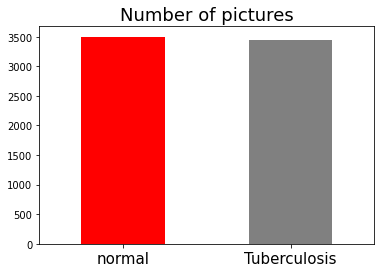

In [5]:
df['Label_String'].value_counts().plot.bar(color = ['red','gray'])
plt.title('Number of pictures', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 15) 
plt.show()

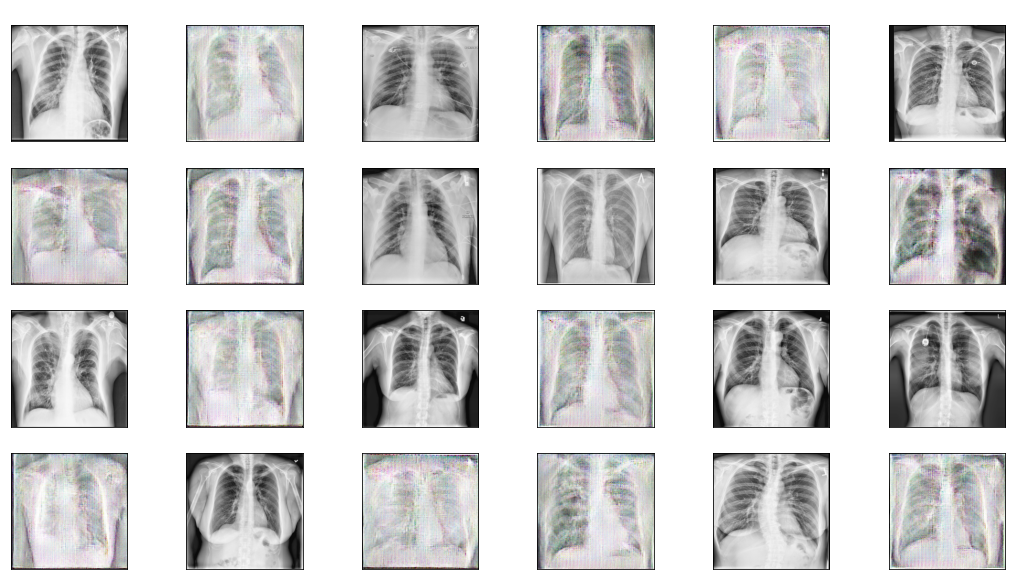

In [8]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = image.load_img(df['Path'].iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = df['Label_String'].iloc[i]
    ax.set_title(title, fontsize = 15, color='white')
plt.tight_layout(pad=0.5)
plt.show()

In [9]:
df_original = df.copy()

# Split into training, test and validation sets
val_index = int(df_original.shape[0]*0.1)

train_df = df_original.iloc[val_index:]
test_df = df_original.iloc[:val_index]

In [10]:
# Display the shapes of the sets
train_df.shape, test_df.shape

((6246, 3), (693, 3))

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label_String',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label_String',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Label_String',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5622 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 693 validated image filenames belonging to 2 classes.


In [29]:
'''#Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False'''

9412608/9406464 [==============================] - 1s 0us/step


In [12]:
from tensorflow.keras.applications import Xception

# Load the pretrained Xception model
pretrained_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False


83689472/83683744 [==============================] - 0s 0us/step


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True),
            learning_rate_reduction
    ]
)

Epoch 1/5
176/176 [==============================] - 82s 429ms/step - loss: 0.1510 - accuracy: 0.9413 - val_loss: 0.0550 - val_accuracy: 0.9856
Epoch 2/5
176/176 [==============================] - 46s 262ms/step - loss: 0.0497 - accuracy: 0.9840 - val_loss: 0.0394 - val_accuracy: 0.9840
Epoch 3/5
176/176 [==============================] - 46s 262ms/step - loss: 0.0433 - accuracy: 0.9847 - val_loss: 0.0447 - val_accuracy: 0.9808

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/5
176/176 [==============================] - 46s 263ms/step - loss: 0.0282 - accuracy: 0.9917 - val_loss: 0.0322 - val_accuracy: 0.9888
Epoch 5/5
176/176 [==============================] - 46s 259ms/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 0.0396 - val_accuracy: 0.9840


# 4. Visualize the result <a class="anchor" id="4"></a>

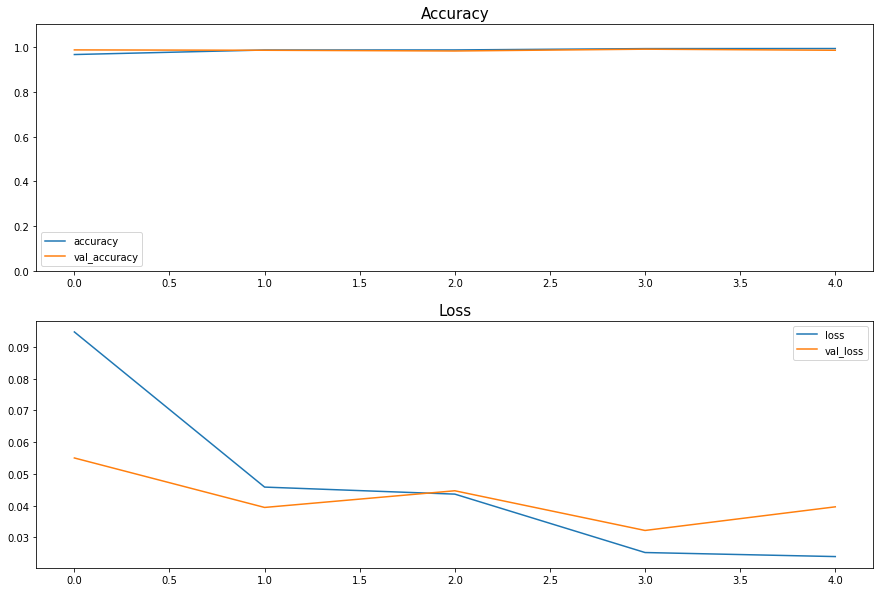

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [15]:
import cv2

def preprocessing(path):
    img = image.load_img(path)
    img = tf.keras.preprocessing.image.img_to_array(img)/255
    img = cv2.resize(img, (224,224))
    return img

# Preprocess the test images
path_lst = test_df['Path'].values
X_test = [preprocessing(p) for p in path_lst]
X_test = np.array(X_test)

# Predict the label
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Inverse the 1 and 0 in the label to adapt to the mapping of the neural network
pred = [0 if x == 1 else 1 for x in pred]


y_test = test_df['Label']

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'{acc*100:.2f}% accuracy on the test set')

97.40% accuracy on the test set

In [20]:
# Get the strings of the prediction
pred = ['Tuberculosis' if x == 1 else 'normal' for x in pred]
y_test = test_df['Label_String']

In [21]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

Tuberculosis       0.00      0.00      0.00         0
      normal       1.00      0.52      0.68       693

    accuracy                           0.52       693
   macro avg       0.50      0.26      0.34       693
weighted avg       1.00      0.52      0.68       693



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


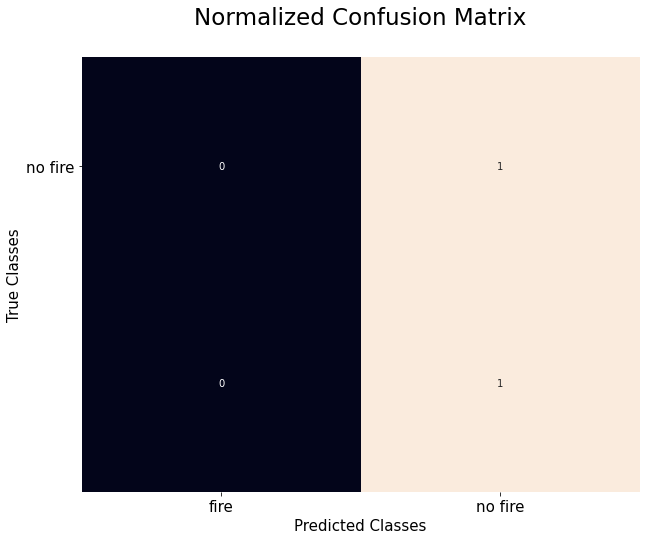

In [25]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(pred)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [25]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "conv2d_3"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

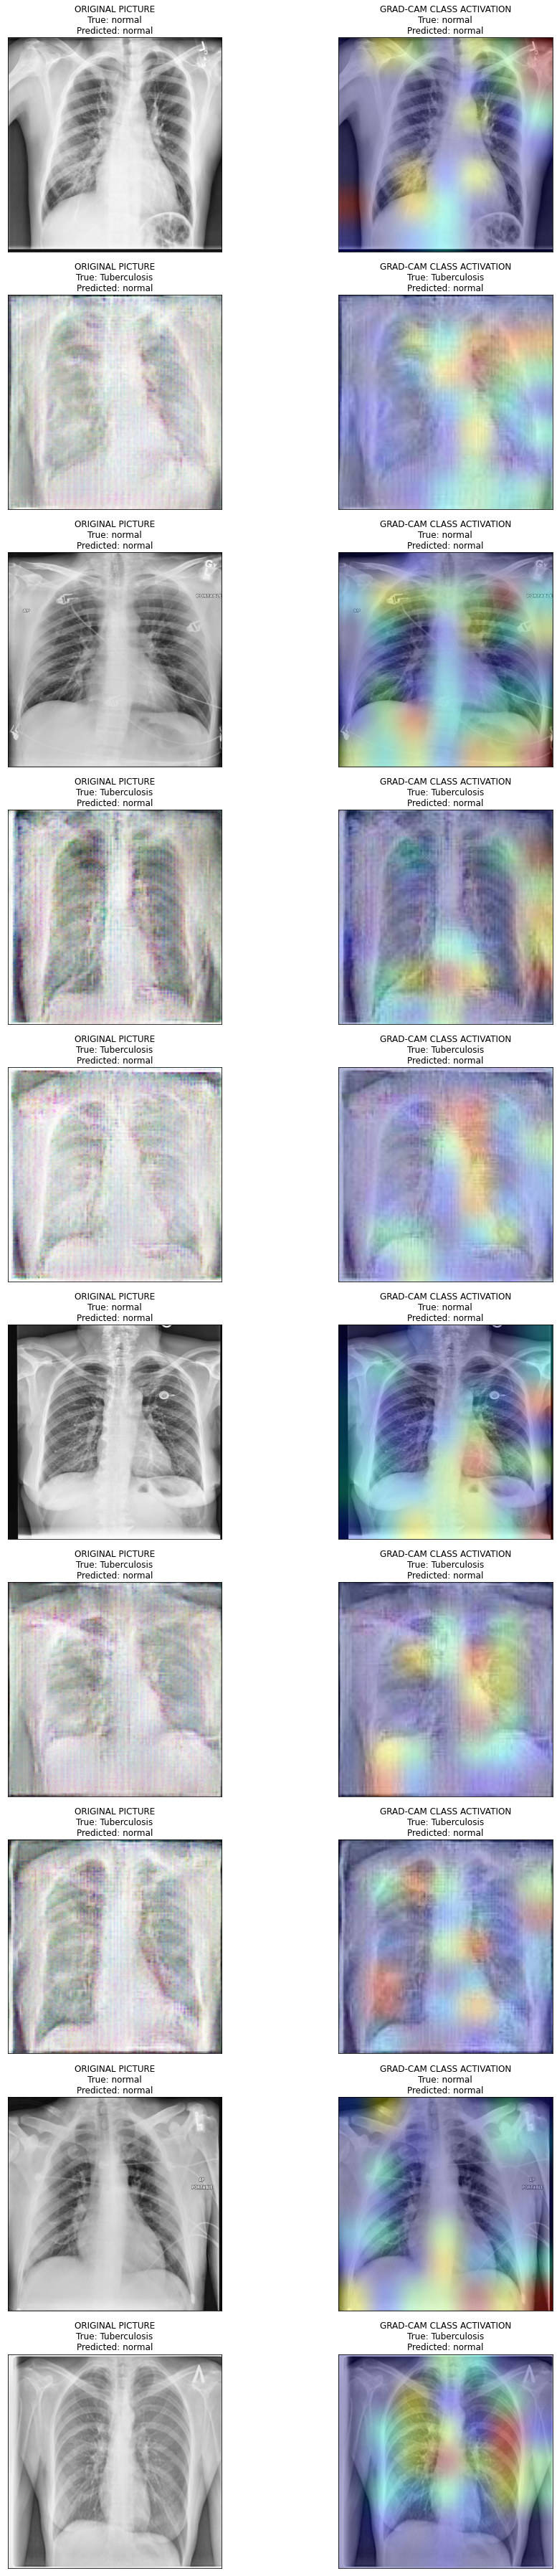

In [26]:
# Display the part of the pictures used by the neural network to classify the pictures
nrows = 10
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows),
                        subplot_kw={'xticks': [], 'yticks': []})

i = 0
for i, nrow in enumerate(range(nrows)):
    
    img_path = test_df.Path.iloc[i]
    title = f"True: {test_df.Label_String.iloc[i]}\nPredicted: {pred[i]}"
    
    # Original Picture
    img = image.load_img(img_path)
    axes[nrow,0].imshow(img)
    axes[nrow,0].set_title('ORIGINAL PICTURE\n' + title)
    
    # Calculate Grad-CAM class activation
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    img = plt.imread(cam_path)
    axes[nrow,1].imshow(img)
    axes[nrow,1].set_title('GRAD-CAM CLASS ACTIVATION\n' + title)

plt.tight_layout()
plt.show()